# Convolutional Neural Network

We implement a simple Convolutional Neural Network in TensorFlow which has a classification accuracy of about 99%.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

## Configuration of Neural Network

In [2]:
# Convolutional Layer 1.
filter_size1 = 5
num_filters1 = 16

# Convolutional Layer 2.
filter_size2 = 5
num_filters2 = 36

# Fully-connected layer.
fc_size = 128

## Load Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

In [6]:
# MNIST images are 28 pixels in each dimension.
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

### Helper-function for plotting images

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 16
    
    fig, axes = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

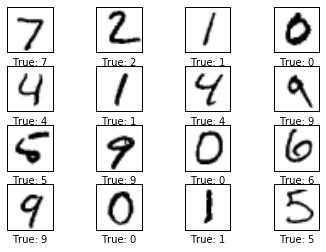

In [8]:
images = data.test.images[0:16]
cls_true = data.test.cls[0:16]
plot_images(images=images, cls_true=cls_true)

### Helper-functions for creating new variables

In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [10]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

In [11]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,        
                   use_pooling=True):  

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

### Helper-function for flattening a layer

In [12]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer

In [13]:
def new_fc_layer(input,          
                 num_inputs,
                 num_outputs,
                 use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables

In [14]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

### Convolutional Layer 1

In [15]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Convolutional Layer 2

In [16]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer

In [17]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [18]:
num_features

1764

### Fully-Connected Layer 1

In [19]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Fully-Connected Layer 2

In [20]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### Predicted Class

In [21]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost-function to be optimized

In [22]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [24]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [25]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64

total_iterations = 0

def optimize(num_iterations):
    global total_iterations

    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

In [26]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:16],
                cls_true=cls_true[0:16],
                cls_pred=cls_pred[0:16])

### Helper-function for showing the performance

In [27]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False):

    num_test = len(data.test.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = data.test.images[i:j, :]
        labels = data.test.labels[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

## Performance before any optimization

In [28]:
print_test_accuracy()

Accuracy on Test-Set: 8.9% (892 / 10000)


## Performance after 1 optimization iteration

In [29]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   7.8%
Time usage: 0:00:00


In [30]:
print_test_accuracy()

Accuracy on Test-Set: 8.9% (892 / 10000)


## Performance after 100 optimization iterations

In [31]:
optimize(num_iterations=99)

Time usage: 0:00:21


Accuracy on Test-Set: 68.7% (6870 / 10000)
Example errors:


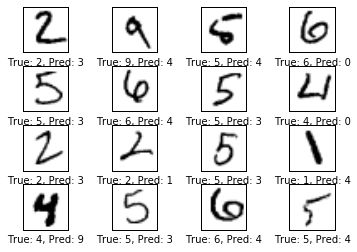

In [32]:
print_test_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations

In [33]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  73.4%
Optimization Iteration:    201, Training Accuracy:  79.7%
Optimization Iteration:    301, Training Accuracy:  73.4%
Optimization Iteration:    401, Training Accuracy:  82.8%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  95.3%
Optimization Iteration:    701, Training Accuracy:  89.1%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  90.6%
Time usage: 0:03:23


Accuracy on Test-Set: 93.2% (9317 / 10000)
Example errors:


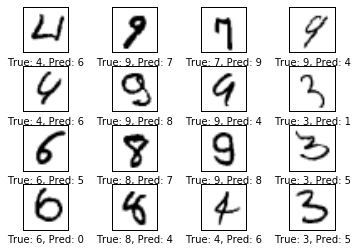

In [34]:
print_test_accuracy(show_example_errors=True)

## Performance after 10,000 optimization iterations

In [35]:
optimize(num_iterations=9000) 

Optimization Iteration:   1001, Training Accuracy:  89.1%
Optimization Iteration:   1101, Training Accuracy:  90.6%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization Iteration:   1801, Training Accuracy:  95.3%
Optimization Iteration:   1901, Training Accuracy:  98.4%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  93.8%
Optimization Iteration:   2201, Training Accuracy:  92.2%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  96.9%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.7% (9867 / 10000)
Example errors:


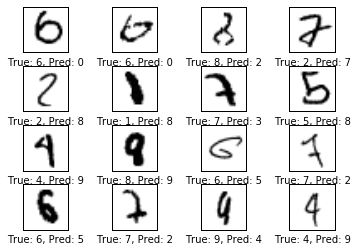

In [37]:
print_test_accuracy(show_example_errors=True)

### Close TensorFlow Session

In [38]:
session.close()